# Part 1. Trivial Numpy Conversion

### The first part is equivalent to Karpathy's video

https://www.youtube.com/watch?v=VMj-3S1tku0

We take his Value class and modify it using numpy. Very easy!

In [1]:
import numpy as np


class Tensor:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = np.array(data)
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self.grad = np.zeros_like(self.data)

    ### string representation
    def __repr__(self):
        return f"Tensor({self.data})"

    ### +
    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        result = Tensor(self.data + other.data, (self, other), "+")
        return result

    ### *
    def __mul__(self, other):
        if isinstance(other, Tensor):
            other = other
        elif isinstance(other, (int, float)):
            other = Tensor([other] * len(self.data))
        else:
            other = Tensor(other)

        result = Tensor(self.data * other.data, (self, other), "*")
        return result
    
    __rmul__ = __mul__

    ### (-)
    def __neg__(self):
        return self * -1

    ### -
    def __sub__(self, other):
        return self + (-other)

    __rsub__ = __sub__

    ### tanh
    def tanh(self):
        x = self.data
        result = Tensor(np.tanh(x), (self, ), "tanh")
        return result 

We can even re use the graph visualization!

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    array_data = np.array2string(n.data, precision=2, separator=',', suppress_small=True)
    grad_data = np.array2string(n.grad, precision=2, separator=',', suppress_small=True) 
    dot.node(name = uid, label = "{ %s | %s | grad %s }" % (n.label, array_data, grad_data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

We start by setting the gradients by hand, just like Karpathy

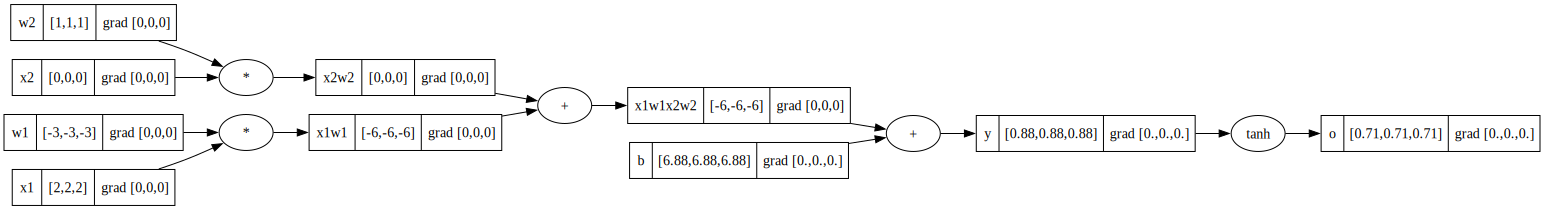

In [3]:
x1 = Tensor([2, 2, 2], label="x1")
w1 = Tensor([-3, -3, -3], label="w1")

x2 = Tensor([0, 0, 0], label="x2")
w2 = Tensor([1, 1, 1], label="w2")

b = Tensor([6.881373587019, 6.881373587019, 6.881373587019], label="b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

y = x1w1x2w2 + b; y.label = "y"

o = y.tanh(); o.label = "o"

draw_dot(o)

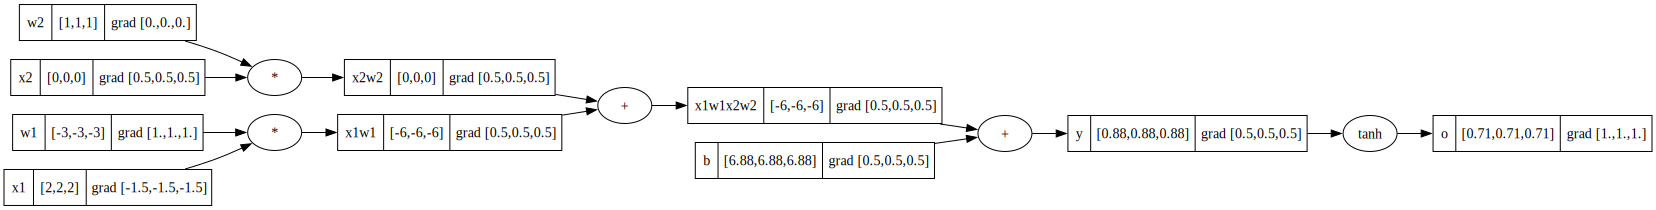

In [4]:
# do/do = 1
o.grad = np.ones_like(o.data)

# do/dy = do/do * do/dy = do/do * (1 - tanh(y)^2) = do/do * (1 - o^2)
y.grad = o.grad * (1 - o.data ** 2)

# do/db = do/dy * dy/db = do/dy * 1
b.grad = y.grad

# do/x1w1x2w2 = do/dy * dy/dx1w1x2w2 = do/dy * 1
x1w1x2w2.grad = y.grad

# do/dx1w1 = do/dy * dy/dx1w1 = do/dy * 1
x1w1.grad = y.grad

# do/dw2w2 = do/dy * dy/dx2w2 = do/dy * 1
x2w2.grad = y.grad

# do/dx1 = do/dx1w1 * dx1w1/dx1 = do/dx1w1 * w1
x1.grad = x1w1.grad * w1.data

# do/dw1 = do/dx1w1 * dx1w1/dw1 = do/x1w1 * x1
w1.grad = x1w1.grad * x1.data

# do/dx2 = do/dx2w2 * dx2w2/dx2 = do/dx2w2 * w2
x2.grad = x2w2.grad * w2.data

# do/dw2 = do/dx2w2 * dx2w2/dw2 = do/dx2w2 * x2
w2.grad = x2w2.grad * x2.data

draw_dot(o)

Now you add backprop

We use '+=' to not override the gradients (check video).

In [5]:
class Tensor:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = np.array(data)
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self.grad = np.zeros_like(self.data)

        ### Add backward function

        self._backward = lambda: None

        ###

    def __repr__(self):
        return f"Tensor({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), "+")

        ### Add the backward function for addition

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        ###

        out._backward = _backward
        return out

    def __mul__(self, other):
        if isinstance(other, Tensor):
            other = other
        elif isinstance(other, (int, float)):
            other = Tensor([other] * len(self.data))
        else:
            other = Tensor(other)

        out = Tensor(self.data * other.data, (self, other), "*")

        ### Add the backward function for multiplication

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        ###

        out._backward = _backward
        return out
    
    __rmul__ = __mul__

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    __rsub__ = __sub__
    
    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Tensor(t, (self, ), "tanh")

        ### Add the backward function for tanh

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        ###

        out._backward = _backward
        return out 

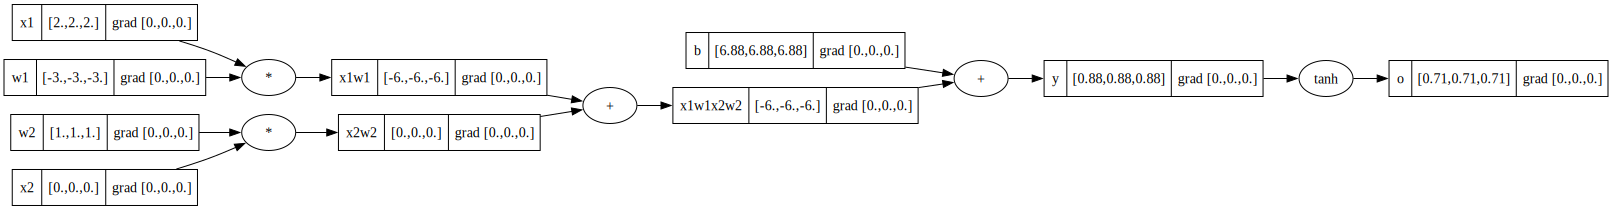

In [6]:
x1 = Tensor([2.0, 2.0, 2.0], label="x1")
w1 = Tensor([-3.0, -3.0, -3.0], label="w1")

x2 = Tensor([0.0, 0.0, 0.0], label="x2")
w2 = Tensor([1.0, 1.0, 1.0], label="w2")

b = Tensor([6.881373587019, 6.881373587019, 6.881373587019], label="b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

y = x1w1x2w2 + b; y.label = "y"

o = y.tanh(); o.label = "o"

draw_dot(o)

Call all the backward passes in order.

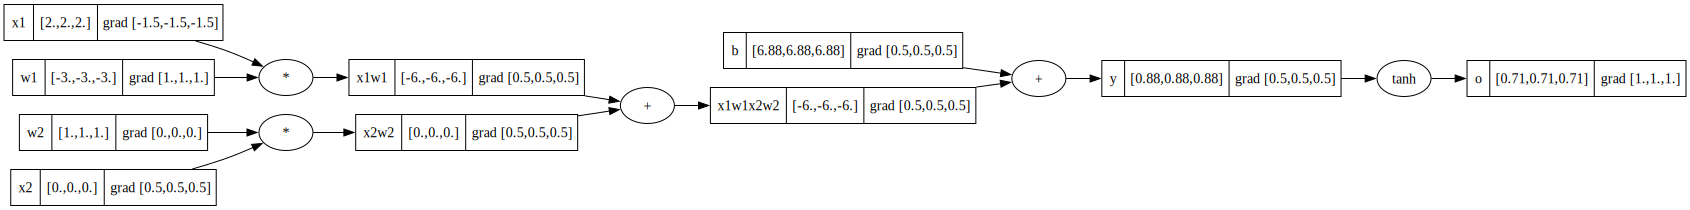

In [7]:
o.grad = np.ones_like(o.data)

o._backward()
y._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
x2._backward()
w2._backward()
b._backward()

draw_dot(o)

Now topological sort (to call the backward functions in order)

It's pretty easy if you think about it, it just checks the top node, checks the children, checks the children, ..., adds them, adds them, ..., adds the top node.

In [8]:
topo = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topological_sort(child)
        topo.append(v)
topological_sort(o)
topo

[Tensor([0. 0. 0.]),
 Tensor([1. 1. 1.]),
 Tensor([0. 0. 0.]),
 Tensor([-3. -3. -3.]),
 Tensor([2. 2. 2.]),
 Tensor([-6. -6. -6.]),
 Tensor([-6. -6. -6.]),
 Tensor([6.88137359 6.88137359 6.88137359]),
 Tensor([0.88137359 0.88137359 0.88137359]),
 Tensor([0.70710678 0.70710678 0.70710678])]

Now we call backwards as before just automatically.

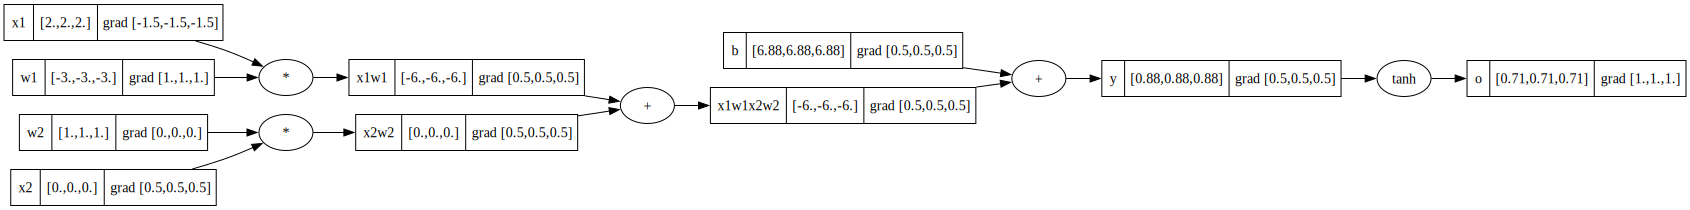

In [9]:
# We set them to 0 first to clear the previous gradients
for node in topo:
    node.grad = np.zeros_like(node.data)

o.grad = np.ones_like(o.data)

for node in reversed(topo):
    node._backward()

draw_dot(o)

Now we add it as a method.

In [10]:
class Tensor:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = np.array(data)
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self.grad = np.zeros_like(self.data)
        self._backward = lambda: None

    def __repr__(self):
        return f"Tensor({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        if isinstance(other, Tensor):
            other = other
        elif isinstance(other, (int, float)):
            other = Tensor([other] * len(self.data))
        else:
            other = Tensor(other)

        out = Tensor(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    __rmul__ = __mul__

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    __rsub__ = __sub__

    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Tensor(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out 

    ### Add backward method

    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        self.grad = np.ones_like(self.data)
        for node in reversed(topo):
            node._backward()

    ###


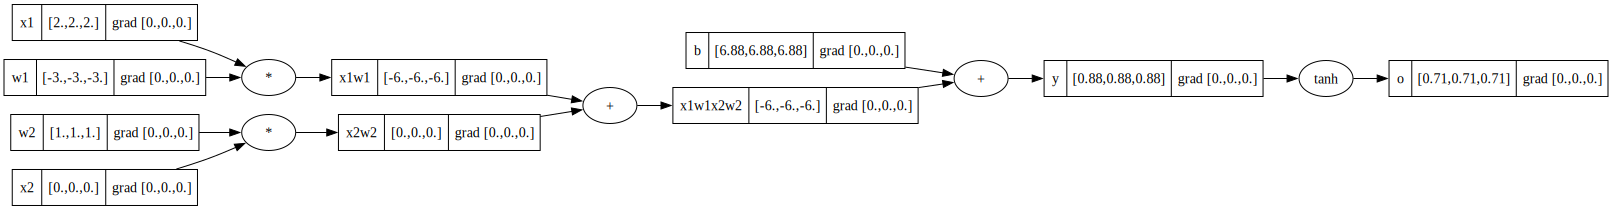

In [11]:
x1 = Tensor([2.0, 2.0, 2.0], label="x1")
w1 = Tensor([-3.0, -3.0, -3.0], label="w1")

x2 = Tensor([0.0, 0.0, 0.0], label="x2")
w2 = Tensor([1.0, 1.0, 1.0], label="w2")

b = Tensor([6.881373587019, 6.881373587019, 6.881373587019], label="b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

y = x1w1x2w2 + b; y.label = "y"

o = y.tanh(); o.label = "o"

draw_dot(o)

Now we can just simply call it

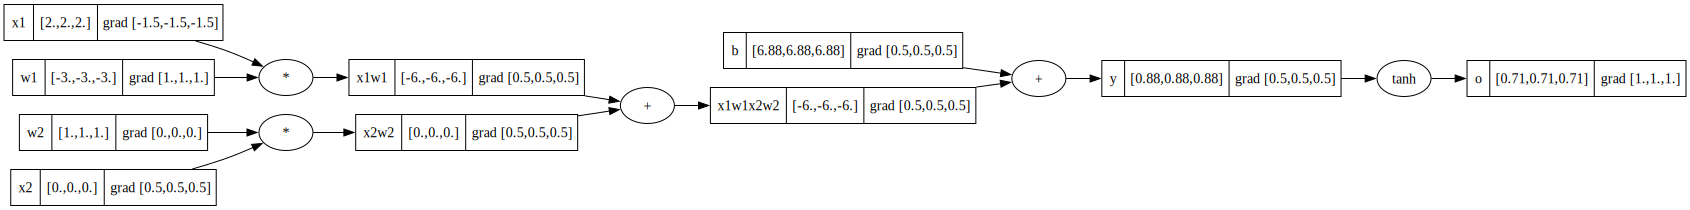

In [12]:
o.backward() # !!!

draw_dot(o)

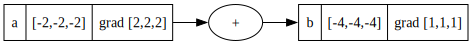

In [13]:
a = Tensor([-2,-2,-2], label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

Now we'll add a bunch of primitive operations and their backward pass

In [14]:
import numpy as np


class Tensor:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = np.array(data)
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self.grad = np.zeros_like(self.data)
        self._backward = lambda: None
        
        ### By default, we don't require gradients

        self.requires_grad = False

        ###

    def __repr__(self):
        return f"Tensor({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), "+")

        ### Check if tensor requires gradients

        def _backward():
            if self.requires_grad:
                self.grad += out.grad
            if other.requires_grad:
                other.grad += out.grad
        out.requires_grad = self.requires_grad or other.requires_grad

        ###

        out._backward = _backward
        return out

    def __mul__(self, other):
        if isinstance(other, Tensor):
            other = other
        elif isinstance(other, (int, float)):
            other = Tensor([other] * len(self.data))
        else:
            other = Tensor(other)

        out = Tensor(self.data * other.data, (self, other), "*")

        ### Check if tensor requires gradients

        out.requires_grad = self.requires_grad or other.requires_grad
        def _backward():
            if self.requires_grad:
                self.grad += other.data * out.grad
            if other.requires_grad:
                other.grad += self.data * out.grad

        ###

        out._backward = _backward
        return out
    
    __rmul__ = __mul__

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    __rsub__ = __sub__

    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Tensor(t, (self, ), "tanh")

        ### Check if tensor requires gradients

        out.requires_grad = self.requires_grad
        def _backward():
            if self.requires_grad:
                self.grad += (1 - t ** 2) * out.grad

        ###

        out._backward = _backward
        return out 


    ###
    ###
    ###

    ### Add exponentiation
    def exp(self):
        x = self.data
        out = Tensor(np.exp(x), (self, ), "exp")

        ### Check if tensor requires gradients
        out.requires_grad = self.requires_grad
        def _backward():
            if self.requires_grad:
                # d/dx exp(x) = exp(x)
                self.grad += out.data * out.grad 

        out._backward = _backward
        return out

    ### Add power
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be int or float"

        # Numpy doesn't support negative power
        def _negative_power(A, x):
            return A ** x if x > 0 else 1 / (A ** -x)

        out = Tensor(_negative_power(self.data, other), (self,), "**")

        ### Check if tensor requires gradients
        out.requires_grad = self.requires_grad
        def _backward():
            if self.requires_grad:
                # d/dx x^a = a * x^(a-1)
                self.grad += other * _negative_power(self.data, other - 1) * out.grad

        out._backward = _backward
        return out

    ### Add division
    def __truediv__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data / other.data, (self, other), "/")
        
        ### Check if tensor requires gradients
        out.requires_grad = self.requires_grad or other.requires_grad
        def _backward():
            if self.requires_grad:
                self.grad += out.grad / other.data
            if other.requires_grad:
                other.grad += -self.data / other.data ** 2 * out.grad

        out._backward = _backward
        return out

    def __rtruediv__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        return other * self ** -1

    ###
    ###
    ###

    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        self.grad = np.ones_like(self.data)
        for node in reversed(topo):
            node._backward()

Let's modify out visualization a bit

In [32]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    ###
    array_data = np.array2string(n.data, precision=2, separator=',', suppress_small=True)
    grad_data = ""
    if n.requires_grad:
      grad_data = np.array2string(n.grad, precision=2, separator=',', suppress_small=True) 
    grad_content = f"| grad {grad_data}" if n.requires_grad else ""
    label_content = f"{n.label} |" if n.label else ""
    dot.node(name = uid, label = "{ %s %s %s }" % (label_content, array_data, grad_content), shape='record')
    ###
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

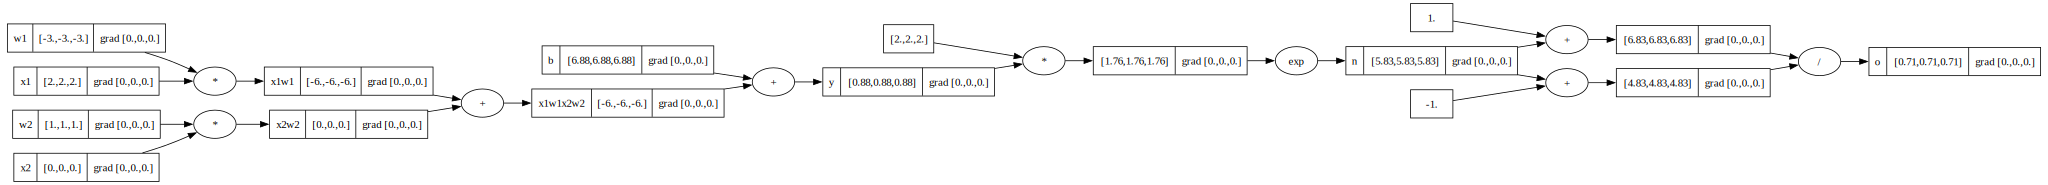

In [16]:
x1 = Tensor([2.0, 2.0, 2.0], label="x1"); x1.requires_grad = True
w1 = Tensor([-3.0, -3.0, -3.0], label="w1"); w1.requires_grad = True

x2 = Tensor([0.0, 0.0, 0.0], label="x2"); x2.requires_grad = True
w2 = Tensor([1.0, 1.0, 1.0], label="w2"); w2.requires_grad = True

b = Tensor([6.881373587019, 6.881373587019, 6.881373587019], label="b"); b.requires_grad = True

x1w1 = x1 * w1; x1w1.label = "x1w1"; x1w1.requires_grad = True
x2w2 = x2 * w2; x2w2.label = "x2w2"; x2w2.requires_grad = True

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"; x1w1x2w2.requires_grad = True

y = x1w1x2w2 + b; y.label = "y"; y.requires_grad = True

e = (2.0*y).exp(); e.label = "n"; e.requires_grad = True

o = (e - 1.0) / (e + 1.0); o.label = "o"; o.requires_grad = True

draw_dot(o)

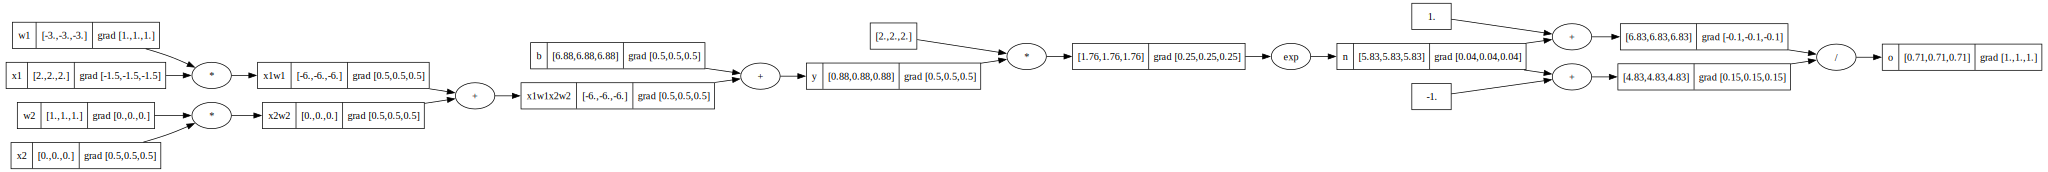

In [17]:
o.backward()

draw_dot(o)

We now make the code more presentable, there's a bit of annoyance

In [18]:
import numpy as np


class Tensor:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = np.array(data)
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.requires_grad = False

        ### Set as None by default
        self.grad = None

    def __repr__(self):
        return f"Tensor({self.data})"
    
    ### Add assert tensor
    def _assert_tensor(self, other):
        return other if isinstance(other, Tensor) else Tensor(other)

    ### Method to set requires_grad
    def requires_grad_(self, requires_grad=True):
        self.requires_grad = requires_grad
        if requires_grad:
            self.grad = np.zeros_like(self.data)
        else:
            self.grad = None
        return self

    def __add__(self, other):
        other = self._assert_tensor(other) ###
        out = Tensor(self.data + other.data, (self, other), "+")

        ### Polished requires_grad
        out.requires_grad = self.requires_grad or other.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += out.grad
                if other.requires_grad:
                    other.grad += out.grad
            out._backward = _backward

        return out

    def __mul__(self, other):
        other = self._assert_tensor(other) ###
        out = Tensor(self.data * other.data, (self, other), "*")

        ### Polished requires_grad
        out.requires_grad = self.requires_grad or other.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += other.data * out.grad
                if other.requires_grad:
                    other.grad += self.data * out.grad
            out._backward = _backward

        return out
    
    __rmul__ = __mul__

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    __rsub__ = __sub__

    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Tensor(t, (self, ), "tanh")

        ### Polished requires_grad
        out.requires_grad = self.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += (1 - t ** 2) * out.grad
            out._backward = _backward

        return out 

    def exp(self):
        x = self.data
        out = Tensor(np.exp(x), (self, ), "exp")

        ### Polished requires_grad
        out.requires_grad = self.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += out.data * out.grad 
            out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be int or float"

        def _negative_power(A, x):
            return A ** x if x > 0 else 1 / (A ** -x)

        out = Tensor(_negative_power(self.data, other), (self,), "**")

        ### Polished requires_grad
        out.requires_grad = self.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += other * _negative_power(self.data, other - 1) * out.grad
            out._backward = _backward

        return out

    def __truediv__(self, other):
        other = self._assert_tensor(other) ###
        out = Tensor(self.data / other.data, (self, other), "/")
        
        ### Polished requires_grad
        out.requires_grad = self.requires_grad or other.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += out.grad / other.data
                if other.requires_grad:
                    other.grad += -self.data / other.data ** 2 * out.grad

            out._backward = _backward

        return out

    def __rtruediv__(self, other):
        return self._assert_tensor(other) / self

        
    ### Let's add a sum method too, we need it
    def sum(self):
        out = Tensor(np.sum(self.data), (self, ), "sum")

        out.requires_grad = self.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    ### The gradient of a sum is 1
                    self.grad += np.ones_like(self.data) * out.grad
            out._backward = _backward

        return out


    def backward(self):
        ### Error if tensor requires_grad is set to False
        if not self.requires_grad:
            raise ValueError("Tensor requires_grad is set to False")

        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        self.grad = np.ones_like(self.data)
        for node in reversed(topo):
            ### Check if tensor requires grad
            if node.requires_grad:
                node._backward()

It should be ok. Now we can create simple NN pieces, just like him

Let's start with a single dimension single it's easier to viz

Tensor(0.6410442254417006)


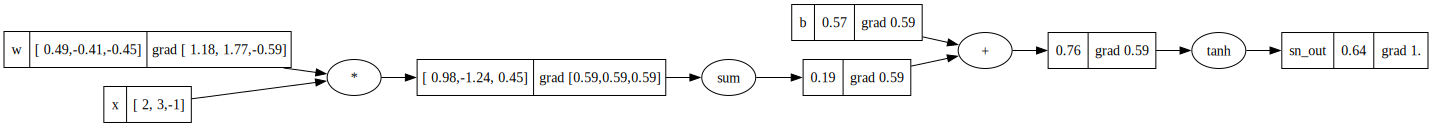

In [19]:
class SimpleLinear:
    
    def __init__(self, nin):
        self.w = Tensor(np.random.uniform(-1, 1, (nin,)), label="w").requires_grad_(True)
        self.b = Tensor(np.random.uniform(-1, 1), label="b").requires_grad_(True)  # Changed to scalar
    
    
    def __call__(self, x):
        # simple sum(W .* X) + b
        y = (self.w * x).sum() + self.b
        out = y.tanh()
        return out

#        ***
#       *   *  tanh(+b1---w1---- x1)
#       *   *  tanh(+b2---w2---- x2)
#       *   *  tanh(+b3---w3---- x3)
#        ***

x_sample = Tensor([2, 3, -1], label="x")

sn = SimpleLinear(3)
sn_out = sn(x_sample); sn_out.label = "sn_out"
print(sn_out)

sn_out.backward()

draw_dot(sn_out)

[Tensor(-0.9558633471770367), Tensor(0.9834017659508487)]


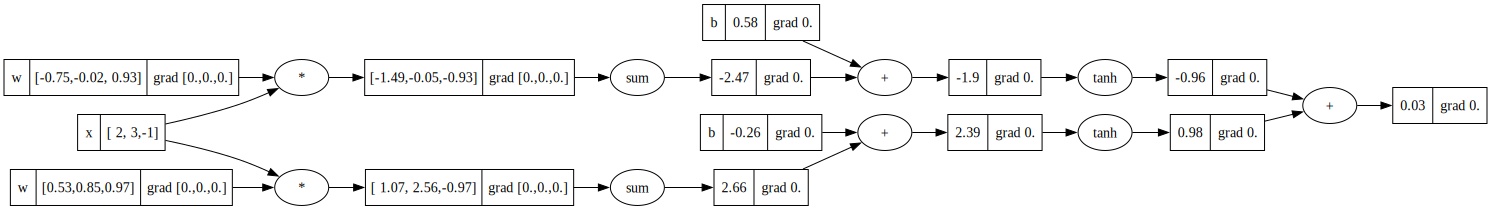

In [20]:
class SimpleSequential:
    
    def __init__(self, nin, nout):
        self.neurons = [SimpleLinear(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        if len(outs) == 1:
            return outs[0]
        return outs

#        ***
#       *   *  tanh(+b11---w11---- x1)
#       *   *  tanh(+b12---w12---- x2)
#       *   *  tanh(+b13---w13---- x3)
#        ***
#        ***
#       *   *  tanh(+b21---w21---- x1)
#       *   *  tanh(+b22---w22---- x2)
#       *   *  tanh(+b23---w23---- x3)
#        ***

x_sample = Tensor([2, 3, -1], label="x")

sl = SimpleSequential(3, 2)
sl_out = sl(x_sample)
print(sl_out)

# Ignore the sum, I just wanted to print the output
draw_dot(sl_out[0] + sl_out[1])

Layer 0 input: Tensor([ 2  3 -1])
Layer 1 input: [Tensor(-0.9999529570913471), Tensor(-0.9119858988897795), Tensor(0.9996487268837184), Tensor(-0.7945302281976291)]
Layer 2 input: [Tensor(Tensor(0.3611600870029342)), Tensor(Tensor(-0.8748235858678217)), Tensor(Tensor(0.8553965790759552)), Tensor(Tensor(-0.30559669031045683))]
Tensor(Tensor(Tensor(-0.43045386566259525)))


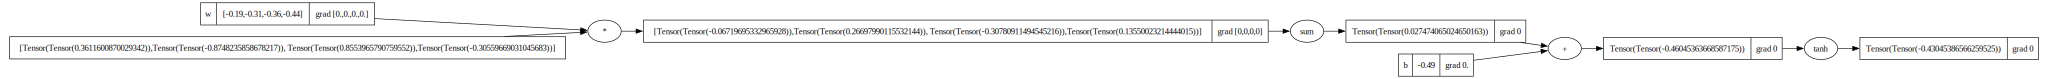

In [21]:
class SimpleMLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        # SimpleLayer takes in sz[i] and outputs sz[i+1]. nout is already sz - 1
        self.layers = [SimpleSequential(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for i, layer in enumerate(self.layers):
            print(f"Layer {i} input: {x}")
            x = layer(x)
        return x
#                  ***
#  x1  -w1-+b1-   *   *  
#  x2  -w2-+b2-   *   *  
#  x3  -w3-+b3-   *   *  
#                  ***
#          ***
#  x1     *   *  
#  x2     *   *  
#  x3     *   *  
#          ***                            x2

sm = SimpleMLP(3, [4,4,1])
sm_out = sm(x_sample)
print(sm_out)
draw_dot(sm_out)

I spent an embarassing amount of time debugging something stupid, let's keep going

Let's just code matmuls directly and forget the rest

Here I actually went into broadcasting hell but it works! 

In [197]:
import numpy as np

class Tensor:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = np.array(data)
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.requires_grad = False
        self.grad = None

        ### Add shape
        self.shape = self.data.shape

    def __repr__(self):
        return f"Tensor({self.data})"
    
    def _assert_tensor(self, other):
        return other if isinstance(other, Tensor) else Tensor(other)

    def requires_grad_(self, requires_grad=True):
        self.requires_grad = requires_grad
        if requires_grad:
            self.grad = np.zeros_like(self.data)
        else:
            self.grad = None
        return self
    
    ###
    ### __add__ broadasting
    ###
    
    def _broadcast_axis(self, left, right):
        # Checking dimesions
        d1, d2 = len(left), len(right)
        m = max(d1, d2)

        # Filling shapes with 1s
        def fill_shape(shape):
            return shape + (1,) * (m - len(shape))

        lshape_new, rshape_new = fill_shape(left), fill_shape(right)

        left_axes, right_axes = [], []
        for i in range(len(lshape_new)):
            if lshape_new[i] > rshape_new[i]:
                right_axes.append(i)
            elif rshape_new[i] > lshape_new[i]:
                left_axes.append(i)

        return tuple(left_axes), tuple(right_axes)

    ### Add broadcast_to (same as numpy)
    ### we'll add broadcasting as a node in the graph
    def broadcast_to(self, shape):
        out = Tensor(np.broadcast_to(self.data, shape), (self,), "broadcast")

        broadcast_axis = self._broadcast_axis(self.shape, shape)[0]

        if self.requires_grad:
            out.requires_grad_()
            def _backward():
                broadcast_grad = np.sum(out.grad, axis=broadcast_axis)
                # Sum can return a scalar, we need to reshape it
                if broadcast_grad.shape != self.shape:
                    broadcast_grad = np.reshape(broadcast_grad, self.shape)
                self.grad += broadcast_grad
            out._backward = _backward

        return out

    def __add__(self, other):
        # Check Tensor
        other = self._assert_tensor(other)

        # Do numpy like broadcasting (might be buggy)
        broadcast_shape = np.broadcast_shapes(self.shape, other.shape)
        # only when needed
        self = self.broadcast_to(broadcast_shape) if self.shape != broadcast_shape else self
        other = other.broadcast_to(broadcast_shape) if other.shape != broadcast_shape else other

        # Now we can add
        out = Tensor(self.data + other.data, (self, other), "+")

        out.requires_grad = self.requires_grad or other.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += out.grad
                if other.requires_grad:
                    other.grad += out.grad
            out._backward = _backward

        return out

    ###
    ### 
    ###

    def __mul__(self, other):
        other = self._assert_tensor(other)
        out = Tensor(self.data * other.data, (self, other), "*")
        out.requires_grad = self.requires_grad or other.requires_grad

        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += other.data * out.grad
                if other.requires_grad:
                    other.grad += self.data * out.grad
            out._backward = _backward

        return out
    
    __rmul__ = __mul__

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    __rsub__ = __sub__

    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Tensor(t, (self,), "tanh")

        out.requires_grad = self.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += (1 - t ** 2) * out.grad
            out._backward = _backward

        return out 

    def exp(self):
        x = self.data
        out = Tensor(np.exp(x), (self,), "exp")

        out.requires_grad = self.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += out.data * out.grad 
            out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be int or float"

        def _negative_power(A, x):
            return A ** x if x > 0 else 1 / (A ** -x)

        out = Tensor(_negative_power(self.data, other), (self,), "**")
        out.requires_grad = self.requires_grad

        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += other * _negative_power(self.data, other - 1) * out.grad
            out._backward = _backward

        return out

    def __truediv__(self, other):
        other = self._assert_tensor(other)
        out = Tensor(self.data / other.data, (self, other), "/")
        out.requires_grad = self.requires_grad or other.requires_grad

        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += out.grad / other.data
                if other.requires_grad:
                    other.grad += -self.data / other.data ** 2 * out.grad
            out._backward = _backward

        return out

    def __rtruediv__(self, other):
        return self._assert_tensor(other) / self

    def sum(self):
        out = Tensor(np.sum(self.data), (self,), "sum")
        out.requires_grad = self.requires_grad

        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad += np.ones_like(self.data) * out.grad
            out._backward = _backward

        return out

    ###
    ### __matmul__ broadcasting
    ###
    
    def __matmul__(self, other):
        # Assert tensor 
        other = self._assert_tensor(other)
        # Dimensions > 0
        n1, n2 = len(self.shape), len(other.shape)
        assert n1 != 0 and n2 != 0, f"arguments to malmul need to be at least 1D, but they are {n1}D and {n2}D"
        # Last dimension of self and first dimension of other must match
        assert (L:=self.shape[-1]) == (R:=other.shape[-min(n2, 2)]), f"Input Tensor shapes {self.shape} and {other.shape} cannot be multiplied ({L} != {R})"

        out = Tensor(self.data @ other.data, (self, other), "@")

        le_axis = (0, ) if self.data.ndim == 1 else ()
        re_axis = (-1, ) if other.data.ndim == 1 else ()
        rese_axis = le_axis + re_axis

        l, r = self._broadcast_axis(self.data.shape[:-2], other.data.shape[:-2])

        out.requires_grad = self.requires_grad or other.requires_grad
        if out.requires_grad:
            out.requires_grad_()
            def _backward():
                if self.requires_grad:
                    self.grad = np.reshape(
                        #  self.grad += out.grad @ other.data.T
                        np.sum(
                            np.expand_dims(out.grad, axis=rese_axis) @
                            # np.expand_dims(other.data, axis=re_axis).swapaxes(-1, -2),
                            np.expand_dims(other.data, axis=re_axis).T,
                            axis = l
                        ),
                        self.data.shape
                    )
                if other.requires_grad:
                    # other.grad += self.data.T @ out.grad
                    other.grad = np.reshape(
                        np.sum(
                            # np.expand_dims(self.data, axis=le_axis).swapaxes(-1, -2) @
                            np.expand_dims(self.data, axis=le_axis).T @
                            np.expand_dims(out.grad, axis=rese_axis),
                            axis = r
                        ),
                        other.data.shape
                    )
            out._backward = _backward

        return out
    ###
    ###
    ###

    def backward(self):
        if not self.requires_grad:
            raise ValueError("Tensor requires_grad is set to False")

        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        self.grad = np.ones_like(self.data)
        for node in reversed(topo):
            if node.requires_grad:
                node._backward()


This is me debugging broadcasting

In [198]:

def _get_axis(self_shape, other_shape):
    d1, d2 = len(self_shape), len(other_shape)
    m = max(d1, d2)

    # Filling shapes with 1s
    def fill_shape(shape):
        return shape + (1,) * (m - len(shape))

    lshape_new, rshape_new = fill_shape(self_shape), fill_shape(other_shape)
    other_shape_axes, self_shape_axes = [], []

    for i in range(len(lshape_new)):
        if lshape_new[i] > rshape_new[i]:
            other_shape_axes.append(i)
        elif rshape_new[i] > lshape_new[i]:
            self_shape_axes.append(i)

    return tuple(self_shape_axes)

# I have 2 shapes
b_self_shape = (1,1)
b_other_shape = (4,1)
print(b_self_shape, b_other_shape)

# Want to broadcast to this
b_broadcast_shape = np.broadcast_shapes(b_self_shape, b_other_shape)
print(b_broadcast_shape)

broadcasted_axes = _get_axis(b_self_shape, b_other_shape)
print(broadcasted_axes)

# We know that the 0th axis needs to be broadcasted

broadcasted_sum = np.sum(np.array([[1]]), axis=broadcasted_axes)
print(broadcasted_sum)

sa_sample = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
np.sum(sa_sample, axis=(0,2))

(1, 1) (4, 1)
(4, 1)
(0,)
[1]


array([30, 48])

Now we create a simple Linear Layer

In [199]:
import math


class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features

        ### Random weight init
        # self.weight = Tensor(np.random.randn(in_features, out_features), label="weight").requires_grad_(True)
        # self.bias = Tensor(np.random.randn(out_features), label="bias").requires_grad_(True)

        ### Torch like weight init
        np.random.seed(42) # For reproducibility and testing
        k = 1 / in_features
        sqrtk = math.sqrt(k)
        self.weight = Tensor(np.random.uniform(-sqrtk, sqrtk, (in_features, out_features)), label="weight").requires_grad_(True)
        self.bias = Tensor(np.random.uniform(-sqrtk, sqrtk, (out_features,1)), label="bias").requires_grad_(True)

    def __call__(self, x):
        return x @ self.weight + self.bias
    
    def parameters(self):
        return [self.weight, self.bias]

Tensor(4.053674678894543)


Python(76235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


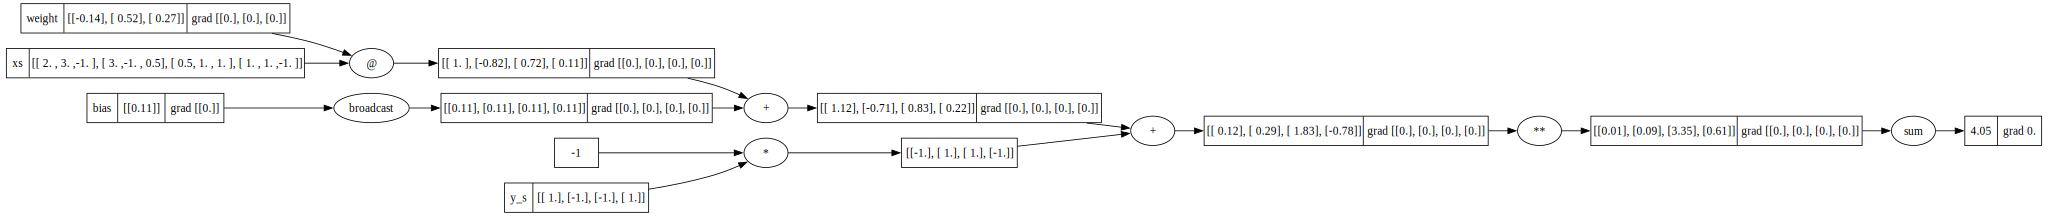

In [200]:
xs = Tensor([
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
], label="xs")

y_s = Tensor(np.array([1.0, -1.0, -1.0, 1.0]).reshape(-1,1), label="y_s")

model = Linear(3, 1)
y_pred = model(xs)
loss = ((y_pred - y_s)**2).sum()
print(loss)

draw_dot(loss)

Python(76034) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


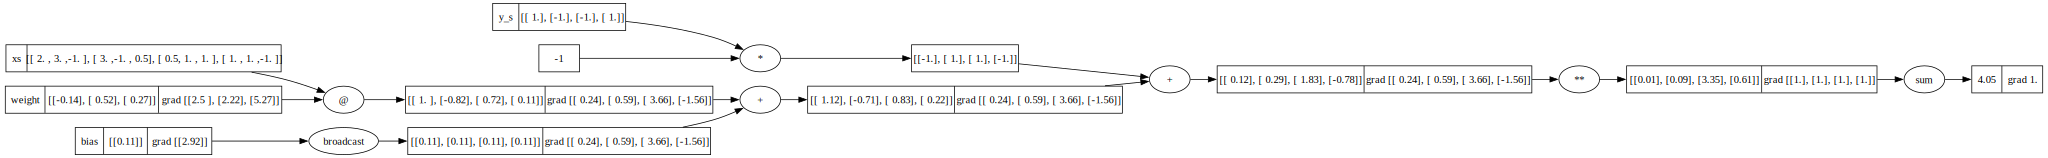

In [188]:
loss.backward()

draw_dot(loss)

I coded the backward pass by hand to check if it was ok. It wasn't

I updated both the add and matmul methods to handle broadcasting. Also check the input shapes

In [168]:
np_xs = np.array([
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
])
np_ys = np.array([1.0, -1.0, -1.0, 1.0])

np_in_features = 3
np_out_features = 1
np.random.seed(42)
np_k = 1 / np_in_features
np_sqrtk = math.sqrt(np_k)
np_W = np.random.uniform(-np_sqrtk, np_sqrtk, (np_in_features, np_out_features))
np_B = np.random.uniform(-np_sqrtk, np_sqrtk, (np_out_features, 1))

np_y = np_xs @ np_W + np_B
print(np_y)
np_loss = ((np_y - np_ys.reshape(-1,1))**2).sum()
print(np_loss)

# Compute gradients
np_d_loss = 2 * (np_y - np_ys.reshape(-1,1))  
print("d_loss")
print(np_d_loss)

np_d_y = np_d_loss 
np_d_W = np_xs.T @ np_d_y
np_d_B = np_d_y.sum(axis=0)

print("d_W, d_B")
print(np_d_W, np_d_B)

[[ 1.11762045]
 [-0.70718306]
 [ 0.82981029]
 [ 0.22160894]]
4.053674678894543
d_loss
[[ 0.23524089]
 [ 0.58563388]
 [ 3.65962058]
 [-1.55678213]]
d_W, d_B
[[2.50041159]
 [2.22292726]
 [5.27397876]] [2.92371323]


It now appears to work

Now let's do gradient descent aka updating the parameters

Python(75862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


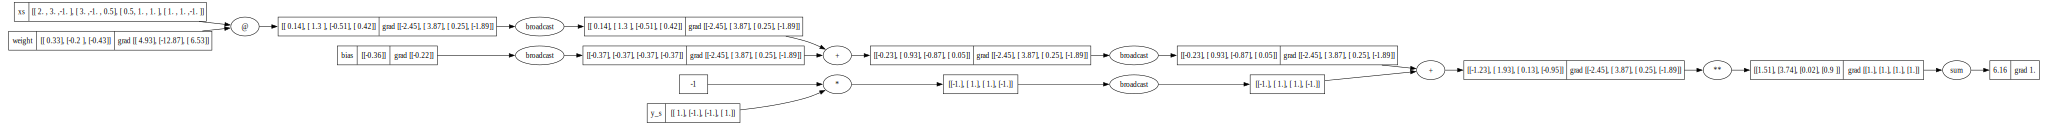

In [169]:
for p in model.parameters():
    p.data += -0.01 * p.grad

draw_dot(loss)

In [170]:
y_pred = model(xs)
loss = ((y_pred - y_s)**2).sum()
print(loss)

Tensor(4.075912783393567)


Very similar to ML from numpy, this can be simplified to 3 steps:

- forward pass
- backward pass
- update

In [171]:
for k in range(10):
    # forward pass
    y_pred = model(xs)
    loss = ((y_pred - y_s)**2).sum()

    # backward pass
    for p in model.parameters():
        p.grad = np.zeros_like(p.data) # set the grads to 0, they accumulate

    loss.backward()
    
    # update weights
    for p in model.parameters():
        p.data += -0.01 * p.grad

    print(f"{k} step: {loss.data} loss")

print("--- Predictions ---")
print(y_pred.data) 
print(loss.data)

0 step: 4.075912783393567 loss
1 step: 2.7532026379915915 loss
2 step: 1.893570789218609 loss
3 step: 1.3274776126602483 loss
4 step: 0.9516179379736427 loss
5 step: 0.7004902275967426 loss
6 step: 0.5316626688485364 loss
7 step: 0.41734136346110495 loss
8 step: 0.33921658598839827 loss
9 step: 0.2851899637402311 loss
--- Predictions ---
[[ 1.02041788]
 [-0.71427245]
 [-0.86394895]
 [ 0.57032227]]
0.2851899637402311


# Part 1.9. MNIST

It'd be pretty cool if we could do MNIST, let's try adding some simple functions


I'll add

- RELU
- softmax
- one hot encoding

Tbh this should be enough to try MNIST, let's give it a shot

In [114]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('../from_numpy/digit-recognizer/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] / 255

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n] / 255
_, m_train = X_train.shape

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 2. Make it do stuff 

This code is not that great, we'll get some type annotation, get some nice separator comments and add functions.

For every function that I add I'll give a short description of how it works and how to get the derivative 

There are 3 Operation Types:

1. Unary Ops - Take a tensor return a tensor of the same size with some operation done (pointwise [each individual element indipendently])
    - exp, log, relu for example
    - mathematically, they're operations with 1 operand (single input). f: A -> A


2. Binary Ops - Take 2 tensors with same size and return a single tensor
    - addition, multiplication, division
    - mathematically, opeartions with 2 operands (2 inputs). f: S x S -> S
        - this is cool bc division is a partial bniary op because 1/0 is undefined!


3. Reduce Ops - Take a n dimensional tensor and turn it into a (n - k) dimensional tensor
    - sum (you take a bunch of number [e.g. 3D] and turn it into a single one [i.e. 0D])


There are actually more, I don't think this is rigorous, like: 


- Movement Ops - different ways of accesing memory
    - like reshapes

- Elementwise Ops - operations that take in 2 tensors with the same shape and output one with the same shape
    - An elementwise op can be binary too, like element wise multiplication
    - an example is raising matrix A to the power of matrix B independently for each element so that A ^ B = (a_ij) / (b_ij)

- etc

# Part 3. Tinygrad

tinygrad is a tensor library, and as a tensor library it has multiple parts
1. a "runtime". this allows buffer management, compilation, and running programs
2. a "Device" that uses the runtime but specifies compute in an abstract way for all
3. a "LazyBuffer" that fuses the compute into kernels, using memory only when needed
4. a "Tensor" that provides an easy to use frontend with autograd ".backward()"

As far as I understand it, it works like this:

1. The "runtime" compiler the programs into AST (abstract syntax tree [this diagram of what to do first, what to do next, what to do last])

2. The "device" is the actual code you're getting, like "metal", the generated kernel codes
    - I have no idea they do this tbh

3. LazyBuffers are the things where you save all computation into kernels until realized
    - this means that a forwards pass A @ B + b would be in a single kernel as opposed to [A @ B] = inter -> [inter + b]
    - maybe the coolest part imo, it's really good performace gains but unpredictive memory usage

4. Tensor. what we already have !!! 

I don't really know how many of these I'll do since that might take a while